# Neurális háló

Itt is a .csv fájlok beolvasásával kezdődik a munka. Mivel hozzáadtam a "Label" oszlopot is így tudok hisztogramot kirajzoltatni.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12875 entries, 0 to 12874
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     12875 non-null  object
 1   Emotion  12875 non-null  object
 2   Label    12875 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 301.9+ KB


array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

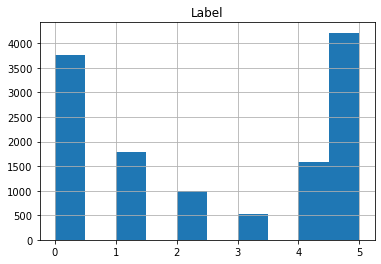

In [1]:
import pandas as pd

df_train = pd.read_csv("../data/emotions_train.csv", sep=",")
df_train.info()
df_train.head()
df_train.hist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     4292 non-null   object
 1   Emotion  4292 non-null   object
 2   Label    4292 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 100.7+ KB


array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

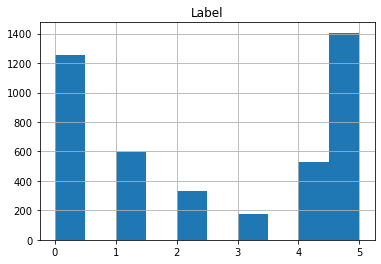

In [2]:
df_val = pd.read_csv("../data/emotions_val.csv", sep=",")
df_val.info()
df_val.head()
df_val.hist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     4292 non-null   object
 1   Emotion  4292 non-null   object
 2   Label    4292 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 100.7+ KB


array([[<AxesSubplot:title={'center':'Label'}>]], dtype=object)

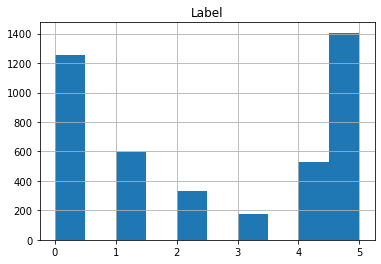

In [3]:
df_test = pd.read_csv("../data/emotions_test.csv", sep=",")
df_test.info()
df_test.head()
df_test.hist()

A ```BertWordPieceTokenizer``` használatával tokeinzáljuk a szöveget.

In [4]:
import numpy as np
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt",
                                   lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result)

Előállítjuk a következőket: ```X_train```, ```X_val```, ```X_test``` a tokenizált szövegekből. Illetve az ```y_train```, ```y_val``` és ```y_test```-et a "Label" értékekből. Ezekre majd a ```model.fit()``` során lesz szükségünk.

In [5]:
import tensorflow as tf

maxlen = 128

X_train = list(df_train["Text"].values)
X_train = bert_tokenizer(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
y_train = df_train["Label"].values

X_val = list(df_val["Text"].values)
X_val = bert_tokenizer(X_val)
y_val = df_val["Label"].values
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)

X_test = list(df_test["Text"].values)
X_test = bert_tokenizer(X_test)
y_test = df_test["Label"].values
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

#print(X_train)
print(y_train)

C:\Users\tunde\AppData\Local\Temp\ipykernel_19888\3104164827.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)


[4 3 0 ... 5 1 2]


Összeállítjuk a modellt amit majd szeretnénk használni. Itt a ```units=6```-ot módosítottam mivel az általam használt adathalmazban 6 különböző osztály jelenik meg így ezt 6-ra módosítottam.

In [6]:
import tensorflow as tf

max_features = 30522  # vocab size

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 8, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(units=6, activation='softmax')
]) 

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 8)            244176    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 32)                32800     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 277,174
Trainable params: 277,174
Non-trainable params: 0
_________________________________________________________________


10 epoch-on keresztül zajlik a taníttatás. A ```.fit()```-en belül a ```class-weight``` beállításával lehet hangolni, ha esetleg egyenetlen eloszlásúak az osztályok. Itt valószínűlegh az én esetemben ezeknek a súlyozását még lehetett volna tovább finomítani.

In [7]:
with tf.device('/CPU:0'):
    h = model.fit(x=X_train, 
                y=y_train,
                epochs=10,
                batch_size=32,
                class_weight={0:1.,
                             1:2.,
                             2:3.,
                             3:6.,
                             4:3.,
                             5:1.},
                validation_data=(X_val, y_val))

Epoch 1/10
403/403 [==============================] - 2s 5ms/step - loss: 3.0466 - accuracy: 0.2259 - val_loss: 1.5422 - val_accuracy: 0.4301
Epoch 2/10
403/403 [==============================] - 1s 4ms/step - loss: 1.9505 - accuracy: 0.6211 - val_loss: 0.9417 - val_accuracy: 0.6789
Epoch 3/10
403/403 [==============================] - 2s 4ms/step - loss: 0.7771 - accuracy: 0.8605 - val_loss: 0.7047 - val_accuracy: 0.7740
Epoch 4/10
403/403 [==============================] - 1s 4ms/step - loss: 0.3574 - accuracy: 0.9413 - val_loss: 0.6462 - val_accuracy: 0.7950
Epoch 5/10
403/403 [==============================] - 2s 4ms/step - loss: 0.1988 - accuracy: 0.9682 - val_loss: 0.6606 - val_accuracy: 0.7968
Epoch 6/10
403/403 [==============================] - 1s 4ms/step - loss: 0.1278 - accuracy: 0.9803 - val_loss: 0.6854 - val_accuracy: 0.8015
Epoch 7/10
403/403 [==============================] - 2s 4ms/step - loss: 0.0834 - accuracy: 0.9898 - val_loss: 0.7270 - val_accuracy: 0.8034
Epoch 

Megnézhetjük, hogyan zajlott a modell tanulási folyamata grafikonokon és különböző értékeken keresztül.

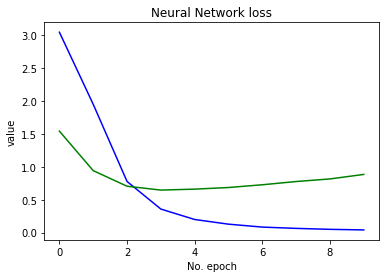

In [8]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='(training data)',color='blue')
plt.plot(h.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

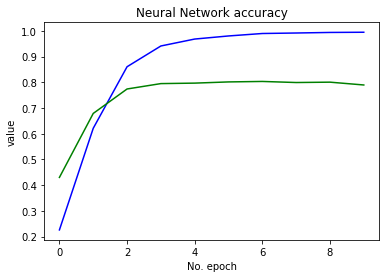

In [9]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'], label='(training data)',color='blue')
plt.plot(h.history['val_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [10]:
with tf.device('/CPU:0'):
    results = model.evaluate(X_test, y_test, batch_size=32)
    print("test loss, test acc:", results)

135/135 [==============================] - 0s 2ms/step - loss: 1.7394 - accuracy: 0.6552
test loss, test acc: [1.7394280433654785, 0.6551724076271057]


In [11]:
df_test_raw = pd.read_csv("../data/emotions_test.csv", sep=",")

Végül meg lehet nézni, hogyan működik a modell. Itt ki fogja írni egy egy szövegre a modell "előrejelzését" illetve hogy mi is a valódi osztálya egy-egy szövegnek.

In [12]:
with tf.device('/CPU:0'):
    predictions = np.round(model.predict(X_test[:100]))
    for i in range(len(predictions)):
        print(df_test_raw["Text"].values[i][:100],"...")
        print("Pred: ", predictions[i], "Real: ", y_test[i])

4/4 [==============================] - 0s 2ms/step
i was feeling rather cranky cos i was thinking about the lack of sleep i had bah ...
Pred:  [0. 1. 0. 0. 0. 0.] Real:  1
i came out of the airport that makes me feel irritable uncomfortable and even sadder ...
Pred:  [0. 1. 0. 0. 0. 0.] Real:  1
i feel dirty watching this series and you can tell how the series is trying to induce false emotions ...
Pred:  [1. 0. 0. 0. 0. 0.] Real:  0
He was so miserabl ...
Pred:  [1. 0. 0. 0. 0. 0.] Real:  0
i feel like a moronic bastard ...
Pred:  [1. 0. 0. 0. 0. 0.] Real:  0
i find enlightening and brilliant when i am feeling joyful can be annoying and slightly grating when ...
Pred:  [0. 0. 0. 0. 1. 0.] Real:  5
i feel lost and then found november i have told jamie this several times ...
Pred:  [0. 1. 0. 0. 0. 0.] Real:  0
i do reviews only on my personal experience please do not feel insulted or put off by my words i int ...
Pred:  [0. 1. 0. 0. 0. 0.] Real:  1
I understood that this was my mother '